# Laser Detection Algorithm
Run the laser detection algorithm.
Use this script for debugging and running on a small scale.

In [45]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
import math
from mpmath import mp
import os
import os.path 
import random
from random import seed
from random import choice
from random import uniform
import mplcursors

## Necessary Functions
First two functions cpied from Anna Zuckerman's Github repository: https://github.com/annazuckerman/specmatch-emp-apf

In [46]:
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)

# function to insert simulated gaussians by adding a gaussian into a given location in the spectrum
def insert_gaussian(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] + gauss
    return new_spect

# same as above, but REMOVES the part of the data where the gaussian is inserted
def insert_gaussian_with_data_removal(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = gauss
    return new_spect
    
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)

## Set parameters

In [47]:
plot = True  # plt.show()
save_figs = True  # save figures into folders

inject_signals = True  # randomly inject signals into data that do not overlap
num_random_injections = 20  # number of injected signals

# for establishing threshold: how many SDs above median is the cutoff
use_local_median = False   # when calculating median of spectra, use 3000 pixels to the left and right of the index instead of the entire spectrum
SDs_above_median = 3   # number of SDs above the median the signal has to be in order to be detected
use_percentage_above_continuum = True
percent_above_continuum = 1.05

threshold_testing = True   # visualize which heights and widths go detected

only_test_certain_range = False  # whether or not to trucnate the spectra or run the algorithm on its entirety 
min_index = 0  # if truncating, which index to start at
max_index = 1000  # if truncating, which index to end at

which_star = 1 # which star to use from list of stars in Anna's folder


# 14, 21, 24, 26, 27
# 20, 28
# weird 38

    
which_star = 24

## Read in Reduced Data from Anna Zuckerman's repo

In [48]:
plt.rcParams["figure.figsize"] = (18,12)
plt.rcParams.update({'font.size': 20})

directory = '/mnt_home/azuckerman/APF_spectra/NDR_corrected_wl_scale'

# every file in Anna's NDR_corrected_wl_scale folder
list_of_files = []
for filename in os.listdir(directory):
    if filename.endswith(".fits"): 
        file_path = os.path.join(directory, filename)
        list_of_files = np.append(list_of_files, file_path)
        
# Choose one star from list of all stars
APF_flux_path = list_of_files[which_star]

file = fits.open(APF_flux_path)
flux = file[0].data
wl = file[1].data

header = file[0].header
star = header['OBJECT']

print('File path: ' + APF_flux_path)
print('Star: ' + star)

if only_test_certain_range == True:
    # truncate wavelength and flux for testing purposes
    wl = wl[min_index:max_index]
    flux = flux[min_index:max_index]

File path: /mnt_home/azuckerman/APF_spectra/NDR_corrected_wl_scale/ranr.211.NDR.fits
Star: HIP21421


In [49]:
if threshold_testing == True:
    # injected signals information
    heights = []
    widths = []
    indicies = []
    wavelengths = []
    max_flux_vals = []
    
    # unrecovered signals information
    unrecovered_heights = []
    unrecovered_widths = []
    unrecovered_indicies = []
    unrecovered_wavelengths = []
    unrecovered_max_flux_vals = []
    
    # unrecovered signals that failed the width or gaussian test
    failed_unrecovered_heights = []
    failed_unrecovered_widths = []
    failed_unrecovered_indicies = []
    failed_unrecovered_wavelengths = []
    failed_unrecovered_max_flux_vals = []
    
    # recovered signals information
    recovered_widths = []
    recovered_heights = []
    recovered_indicies = []
    recovered_wavelengths = []
    recovered_max_flux_vals = []
    
    # uninjected detected signals information
    detected_widths = []
    detected_heights = []
    detected_indicies = []
    detected_wavelengths = []
    detected_max_flux_vals = []

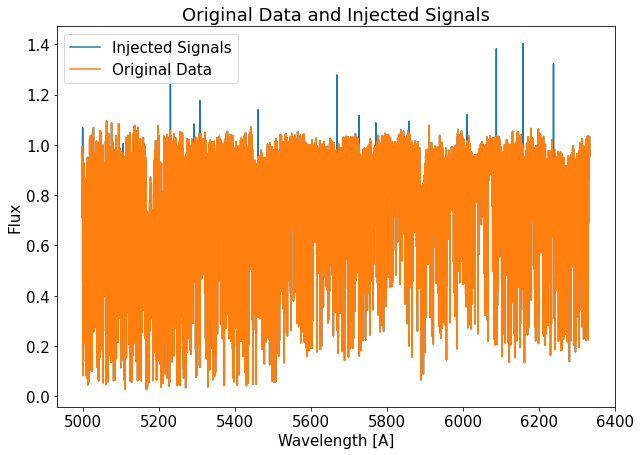

median is 0.8604738320618687
SD is 0.21104753807739327


In [50]:
plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams.update({'font.size': 15})

spect = flux

if inject_signals == True:

    # inject random signals with no overlap
    interval = len(spect) / num_random_injections
    for i in np.arange(interval, len(spect), interval):
        
        
        random_val = np.random.choice(flux[int(i - interval + 30):int(i - 30)])
        location = flux.tolist().index(random_val)
        height = uniform(0.1, 0.5)
        width = uniform(1, 8)           

        if width > 8:
            position = 15
            numpoints = 30
        elif width > 5:
            position = 10
            numpoints = 20
        else:
            position = 5
            numpoints = 10

        # create a copy of the spectra to insert PERFECT gaussians instead of adding the gaussians into the data
        # in order to calculate the pixel width of each inserted gaussian 
        copy_of_spect = spect[:]
        copy_of_spect = insert_gaussian_with_data_removal(copy_of_spect, [height, position, width, 1], location, numpoints)

        spect = insert_gaussian(spect,[height, position, width, 0], location, numpoints)
        heights = np.append(heights, height)
        
        # find maximum flux value of the inserted signal
        flux_vals = spect[location - int(numpoints / 2) : location + int(numpoints / 2)]
        max_flux_val = max(flux_vals)
        max_flux_vals = np.append(max_flux_vals, max_flux_val)
        
        
        # find width of gaussian in pixels

        x = wl[location - int(numpoints / 2) : location + int(numpoints / 2)]
        y = copy_of_spect[location - int(numpoints / 2) : location + int(numpoints / 2)]

        oversampled_x = np.linspace(x[0], x[-1], len(x) * 1000)
        spl = splrep(x, y)
        oversampled_y = splev(oversampled_x, spl)

#         plt.plot(x, y)
#         plt.plot(oversampled_x, oversampled_y)
#         for i in np.arange(-5, 5):
#             plt.axvline(x=wl[location + i], color='gray', linestyle='--')

        peak = max(oversampled_y)
        half_max = peak - height / 2

        peak_index = oversampled_y.tolist().index(peak)
        temp_left_bound = peak_index
        temp_right_bound = peak_index

        while oversampled_y[temp_left_bound] > half_max and temp_left_bound > 0:
            temp_left_bound -=1

        while oversampled_y[temp_right_bound] > half_max and temp_right_bound < len(oversampled_y) - 1:
            temp_right_bound += 1

        pixel_width = (temp_right_bound - temp_left_bound) / 1000
#         plt.title('Injected signal with pixel of ' + str(pixel_width))
#         plt.show()

        widths = np.append(widths, pixel_width)
        indicies = np.append(indicies, location)
        wavelengths = np.append(wavelengths, wl[location])

if (plot == True) or (save_figs == True):
    fig = plt.figure()
    if inject_signals == True: 
        plt.plot(wl, spect, label = 'Injected Signals')
        plt.title('Original Data and Injected Signals')
        if use_local_median:
            global_median = np.median(spect)
            global_SD = np.std(spect)
            plt.axhline(SDs_above_median * global_SD + global_median, label= str(SDs_above_median) + ' SDs above median', color='green', linestyle='--')
    else:
        plt.title('Original Data')
        global_median = np.median(flux)
        global_SD = np.std(flux)
        plt.axhline(SDs_above_median * global_SD + global_median, label= str(SDs_above_median) + ' SDs above median', color='green', linestyle='--')  
    plt.plot(wl, flux, label = 'Original Data')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.legend()
if plot == True:
    plt.show()
# if save_figs == True:
#     path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/LaserDetectionResults/' + star
#     if not (os.path.isdir(path)):
#         os.mkdir(path)
#     fig.savefig(path + '/' + star + '_injected_signals.png')
    
global_median = np.median(spect)
global_SD = np.std(spect)
print('median is ' + str(global_median))
print('SD is ' + str(global_SD))

In [51]:
idxs1 = [] # indicies that are 3 SDs above the median flux value
idxs2 = [] # indicies in idxs1 that are local maximums
idxs3 = [] # indicies in idxs2 that are greater than 5 pixels in width
idxs4 = [] # indicies in idxs3 that are gaussian-shaped

for idx in np.arange(len(spect)):
    if use_local_median == True:
        # first test: create an array of all indices that are above 3 SDs above local median
        if idx < 3000:
            median = np.median(spect[100 : idx + 3000])
            SD = np.std(spect[100 : idx + 3000])
        elif idx > len(spect) - 3000:
            median = np.median(spect[idx - 3000 : len(spect) - 100])
            SD = np.std(spect[idx - 3000 : len(spect) - 100])
        else:
            median = np.median(spect[idx - 3000: idx + 3000])
            SD = np.std(spect[idx - 3000: idx + 3000])

        if spect[idx] > SDs_above_median * SD + median:
            idxs1 = idxs1 + [idx]
    if use_percentage_above_continuum == True:
        # first test: create an array of all indices that 10% or more above the continuum level
        if idx < 3000:
            continuum = np.percentile(spect[100 : idx + 3000], 95)
        elif idx > len(spect) - 3000:
            continuum = np.percentile(spect[idx - 3000 : len(spect) - 100], 95)
        else:
            continuum = np.percentile(spect[idx - 3000: idx + 3000], 95)
        threshold = continuum * percent_above_continuum

        if spect[idx] > threshold:
            idxs1 = idxs1 + [idx]

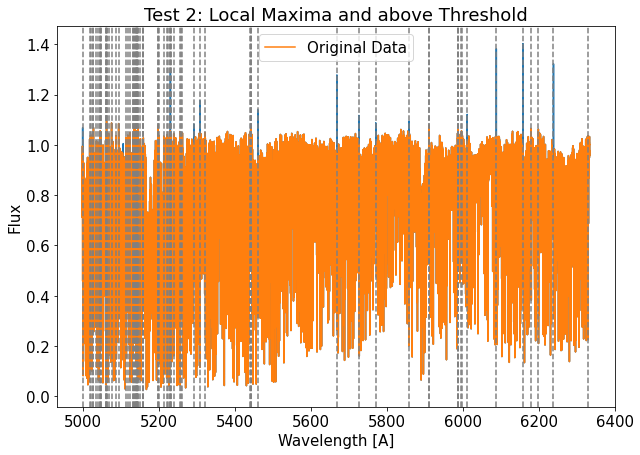

In [52]:
for idx in idxs1:            
    # second test: keep the index if it is a local maximum  
    if spect[idx] >= spect[idx-1] and spect[idx] >= spect[idx+1]: 
        if spect[idx] >= spect[idx-2] and spect[idx] >= spect[idx+2]:
            idxs2 = idxs2 + [idx]
if (plot == True or save_figs == True) & (idxs2 != []):
    fig = plt.figure()
    plt.plot(wl, spect)
    plt.plot(wl, flux, label = 'Original Data')
    for ind in idxs2:
        plt.axvline(x=wl[ind], color='gray', linestyle='--')
    if use_local_median:
        plt.axhline(SDs_above_median * SD + median, label= str(SDs_above_median) + ' SDs above median', color='green', linestyle='--')
        plt.title('Test 2: Local Maxima and' + str(SDs_above_median) + ' SDs Above Median')
    else:
        plt.title('Test 2: Local Maxima and above Threshold')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.legend() 
    if plot == True:
        plt.show()
#     if save_figs == True:
#         path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/LaserDetectionResults/' + star
#         if not (os.path.isdir(path)):
#             os.mkdir(path)
#         fig.savefig(path + '/' + star + 'test2.png')

In [53]:
print(idxs2)

[52, 1137, 1272, 1587, 1727, 2185, 2431, 2774, 2791, 2842, 2859, 3592, 3709, 3717, 3740, 3863, 4048, 4508, 5205, 5584, 6680, 6987, 7291, 7765, 7830, 7949, 8025, 8051, 8164, 8292, 8327, 8374, 8404, 8411, 8535, 8545, 8889, 9284, 9310, 9329, 11527, 11534, 11671, 12390, 12910, 12959, 13348, 13375, 13451, 13469, 13863, 14772, 14871, 15154, 16824, 17710, 18451, 25013, 25049, 25053, 25117, 26081, 37106, 40107, 42381, 46840, 49458, 49483, 53177, 53211, 53227, 53626, 53695, 54430, 58168, 61538, 62538, 63480, 65368, 69617]


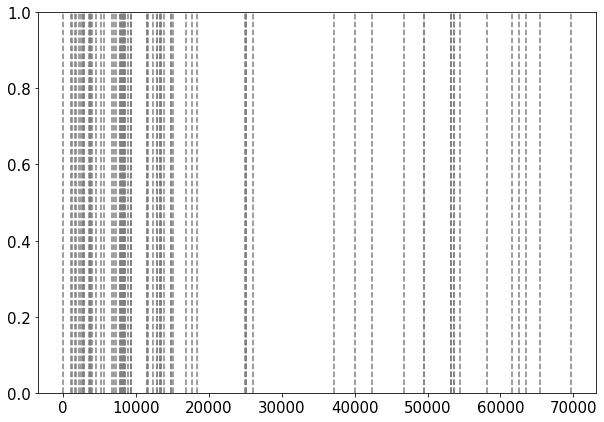

In [54]:
for ind in idxs2:
    plt.axvline(x=ind, color='gray', linestyle='--')

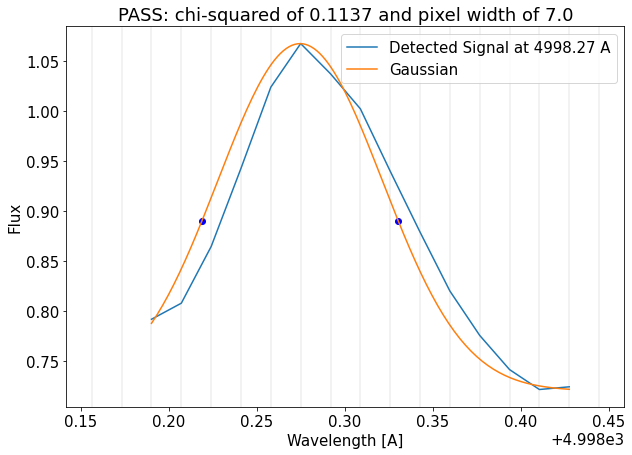

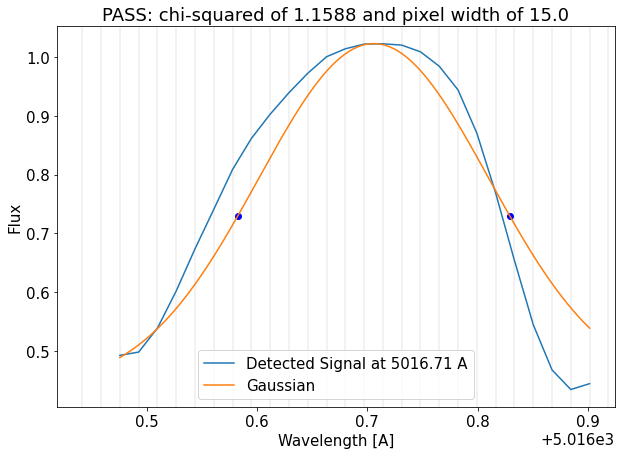

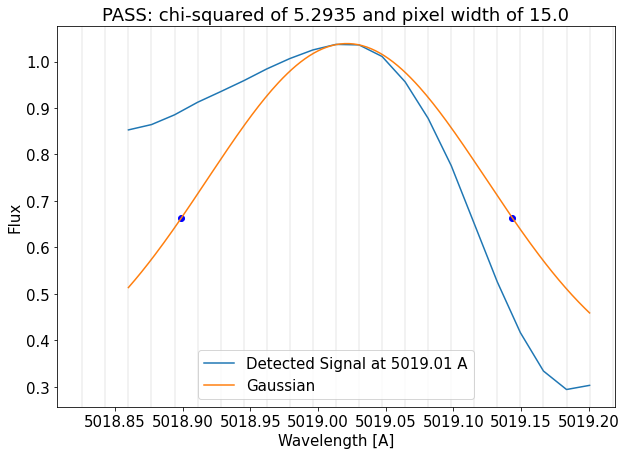

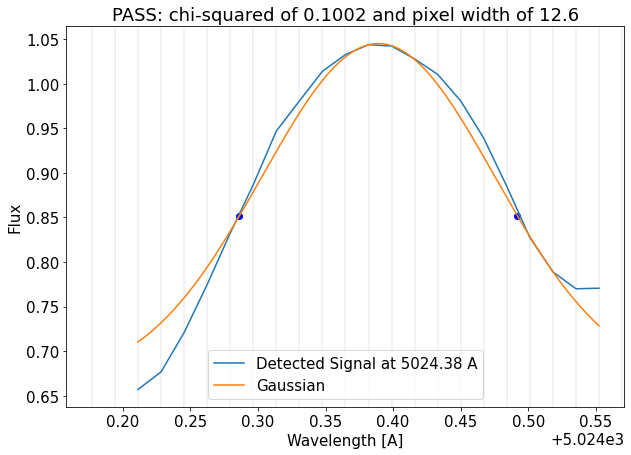

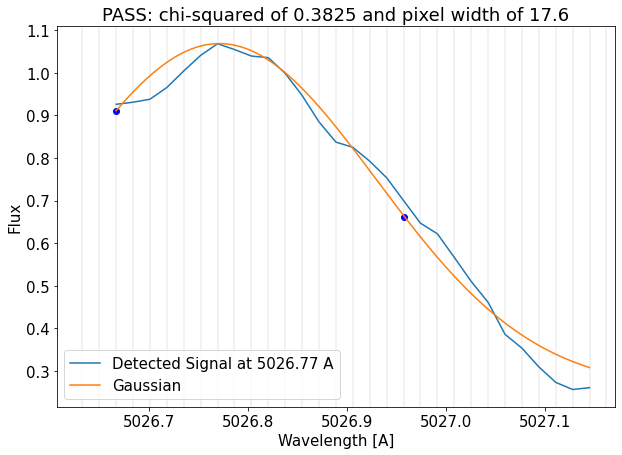

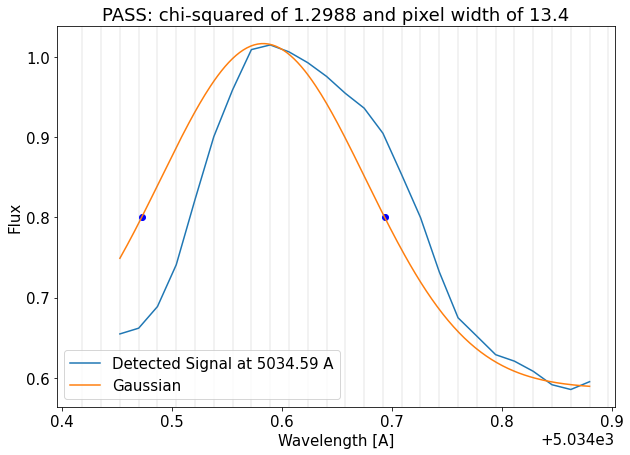

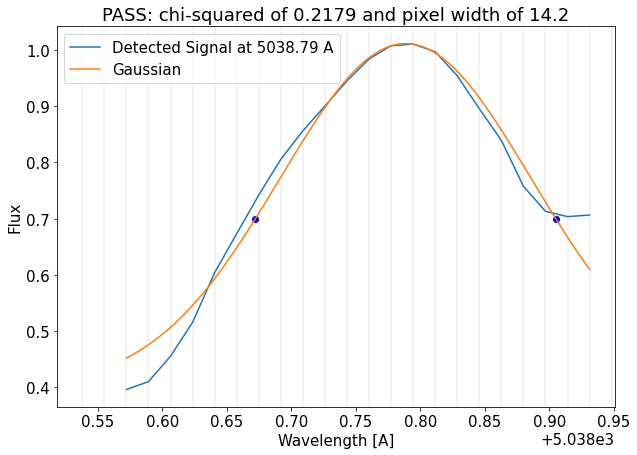

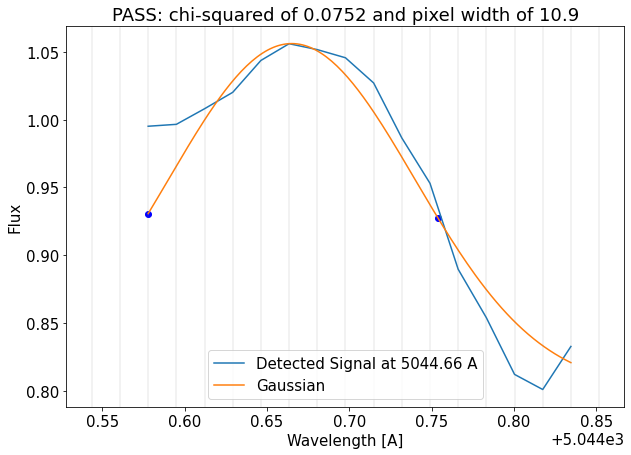

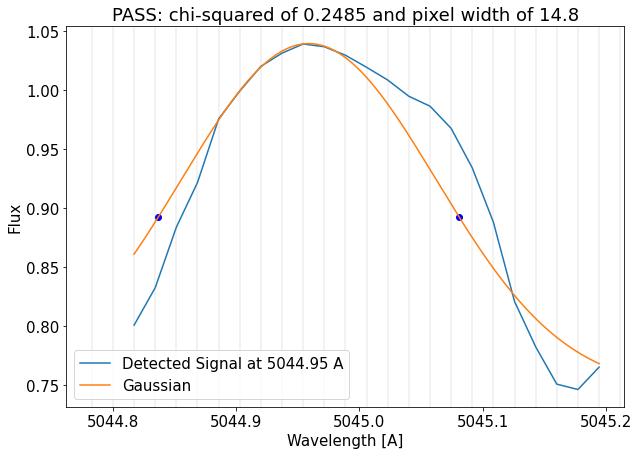

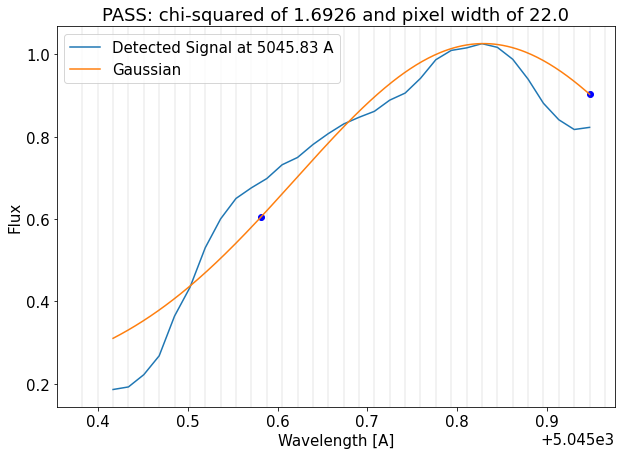

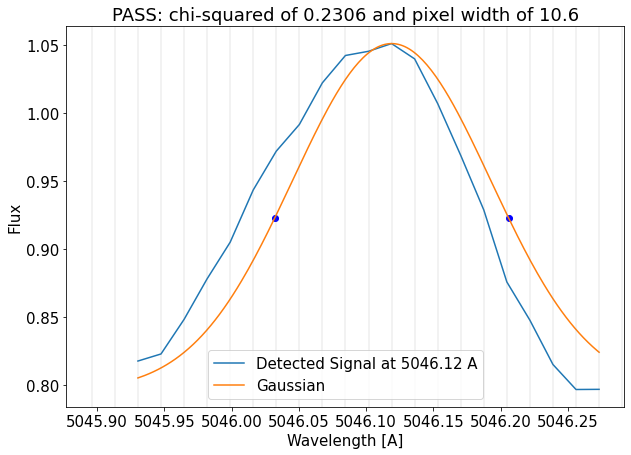

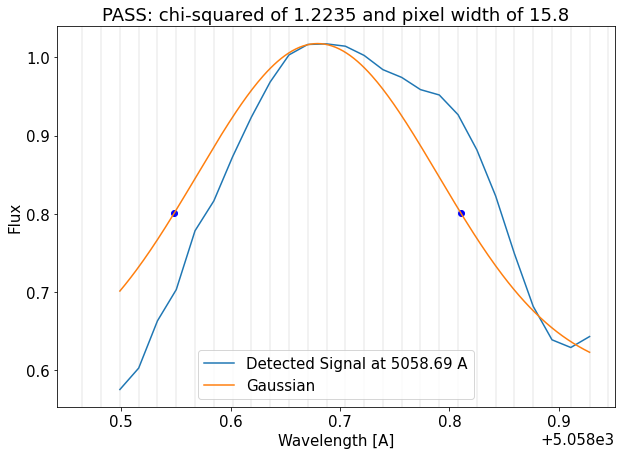

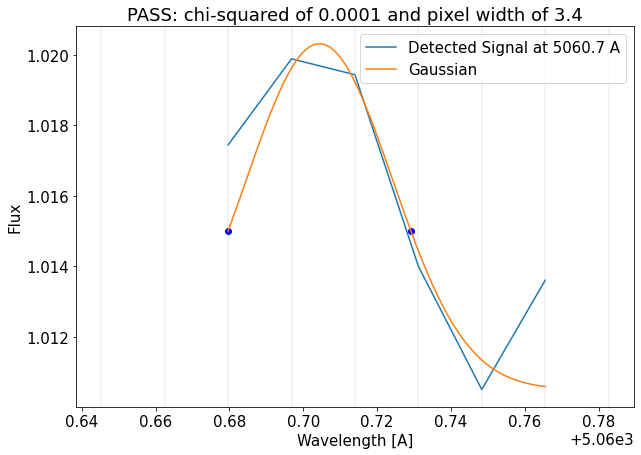

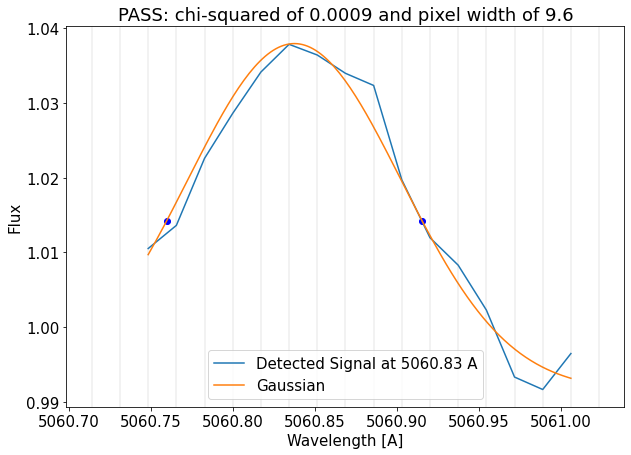

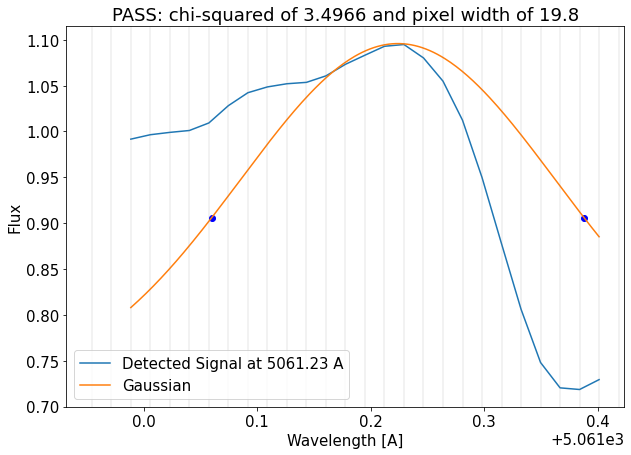

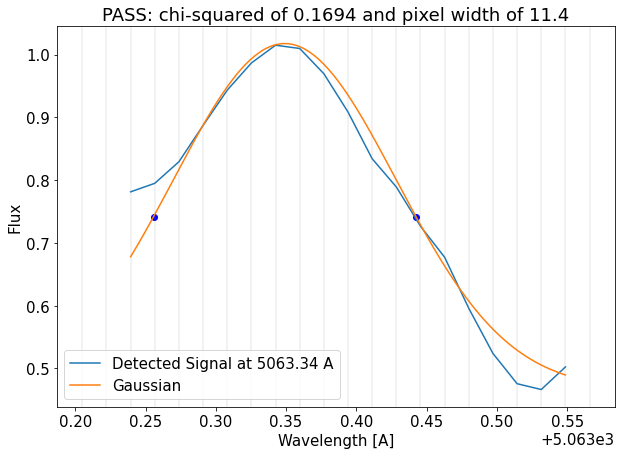

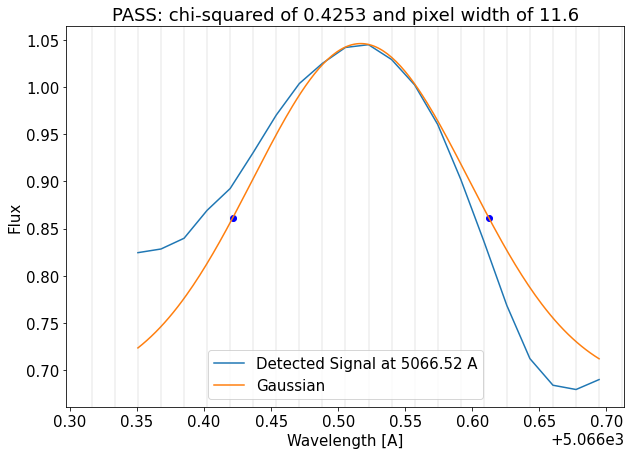

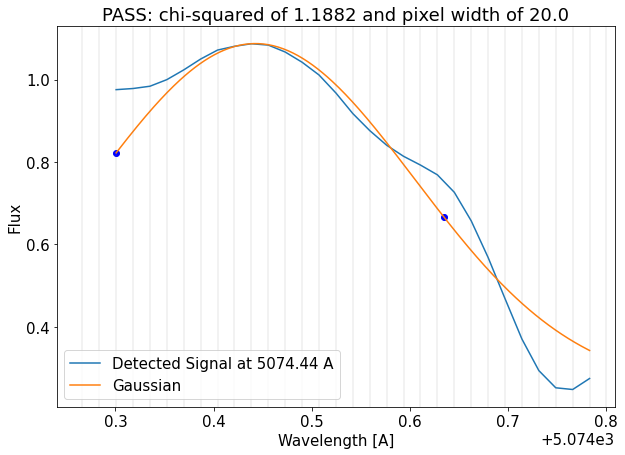

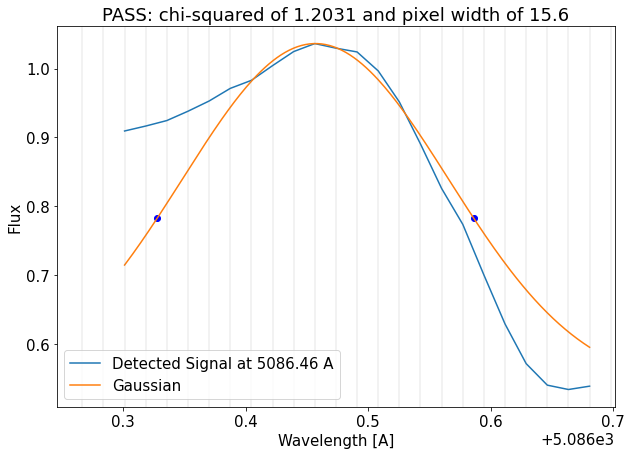

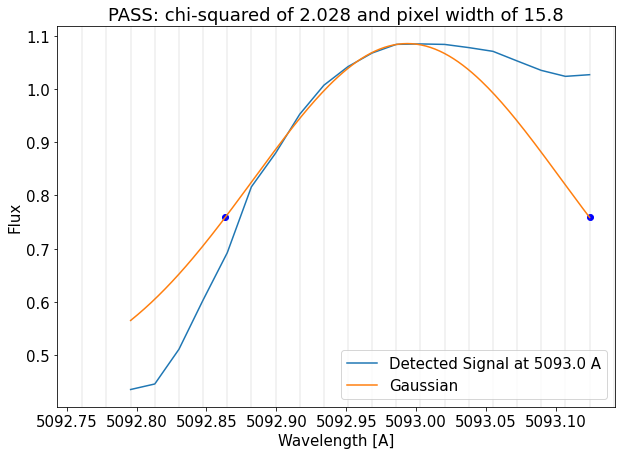

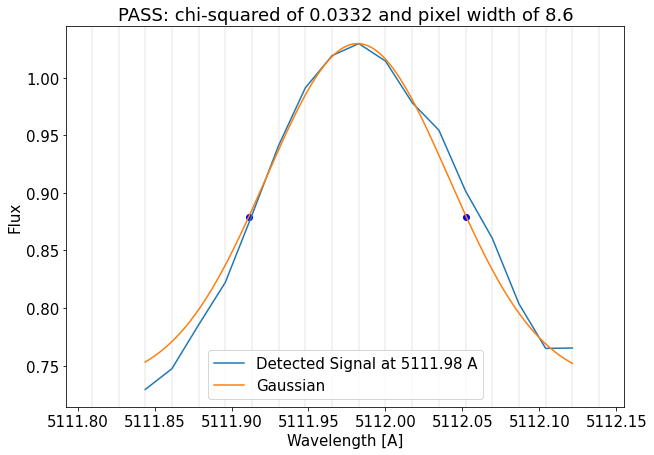

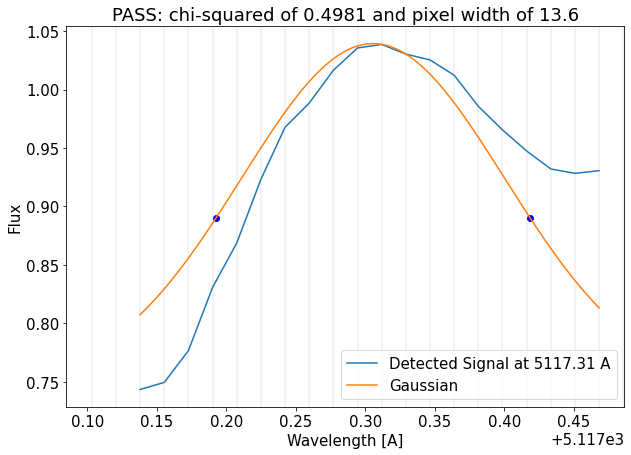

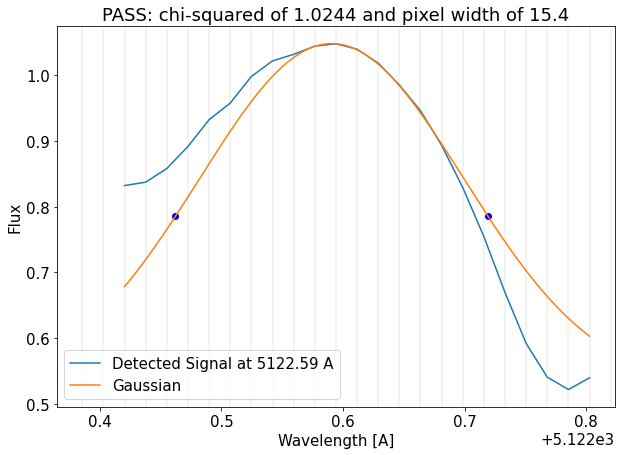

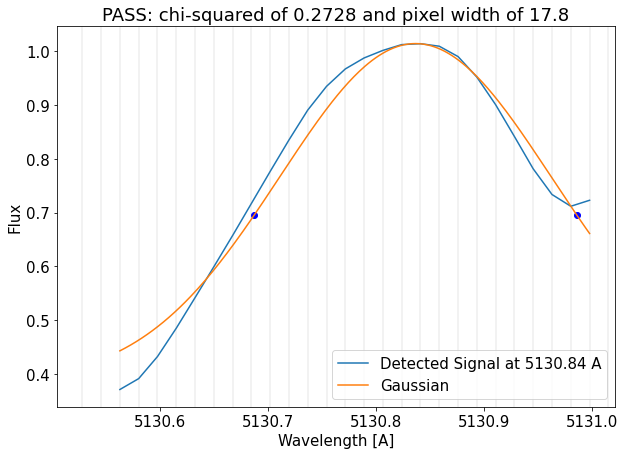

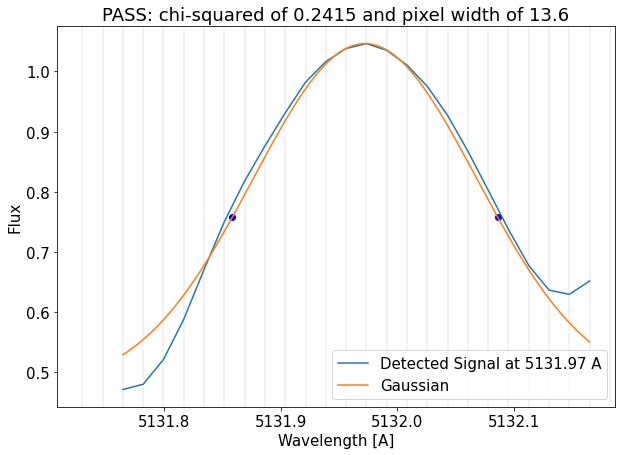

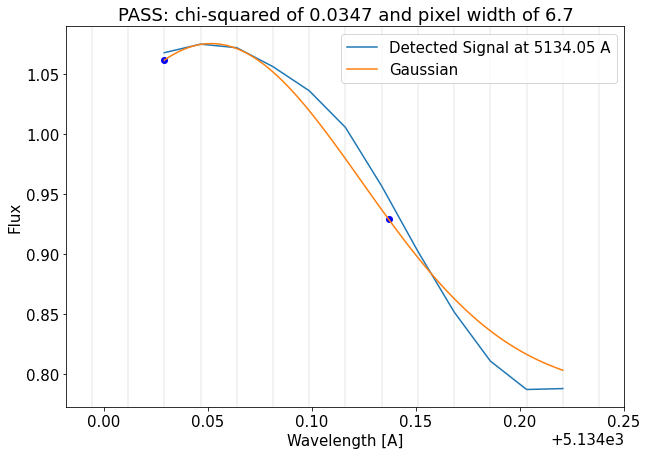

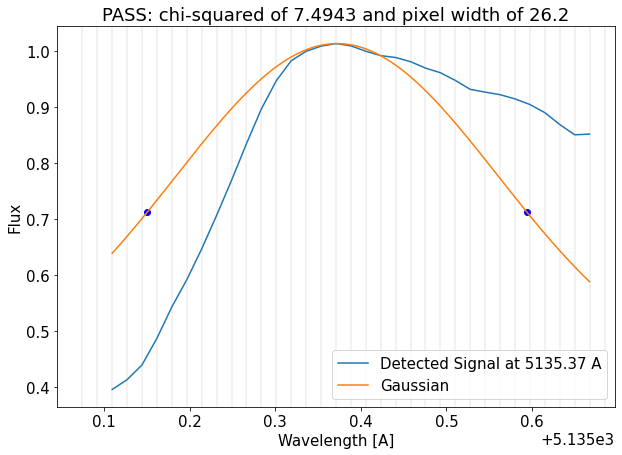

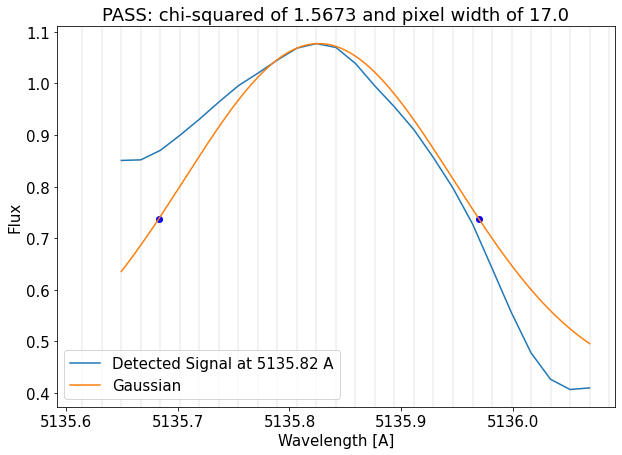

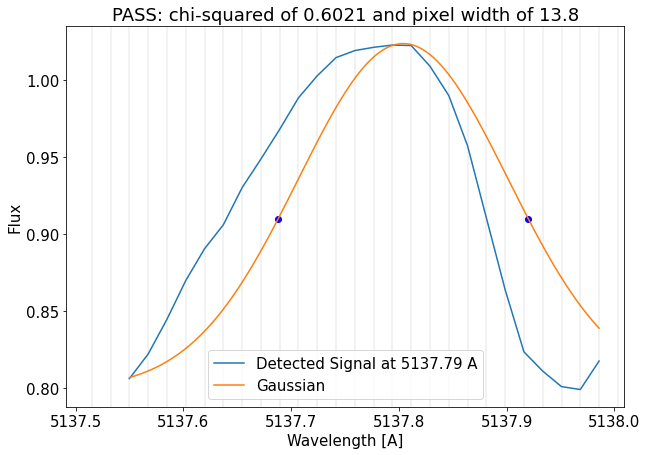

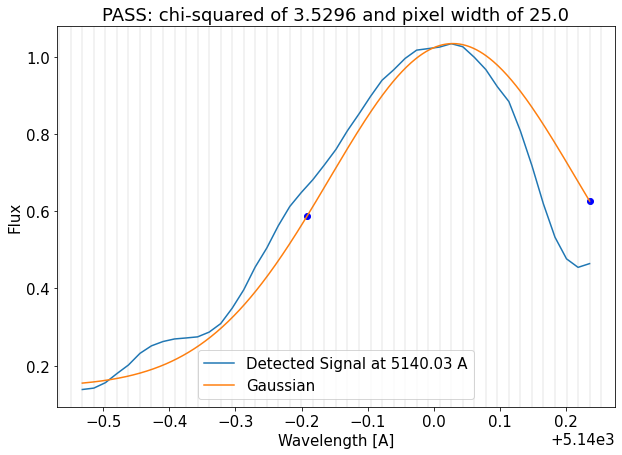

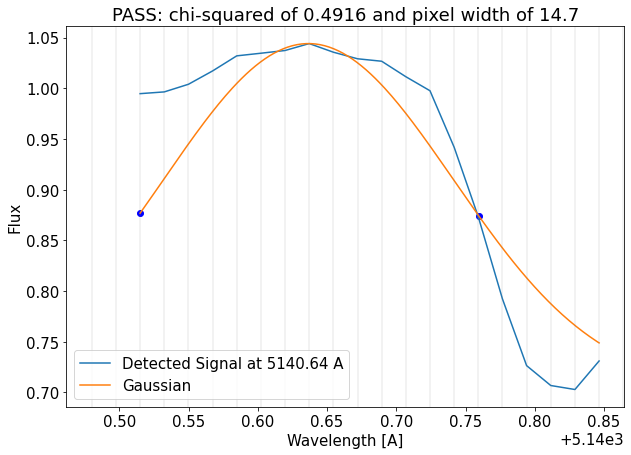

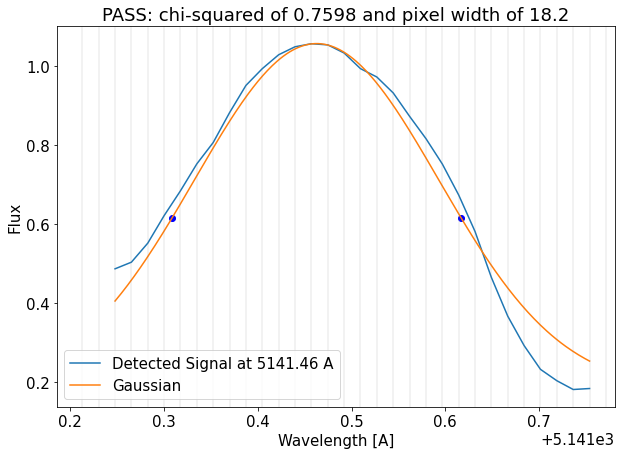

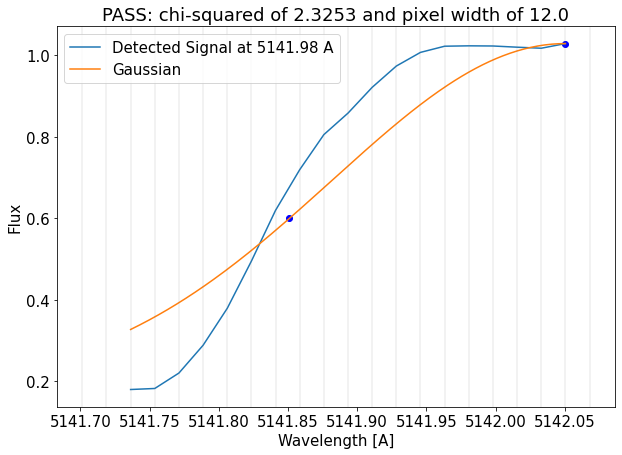

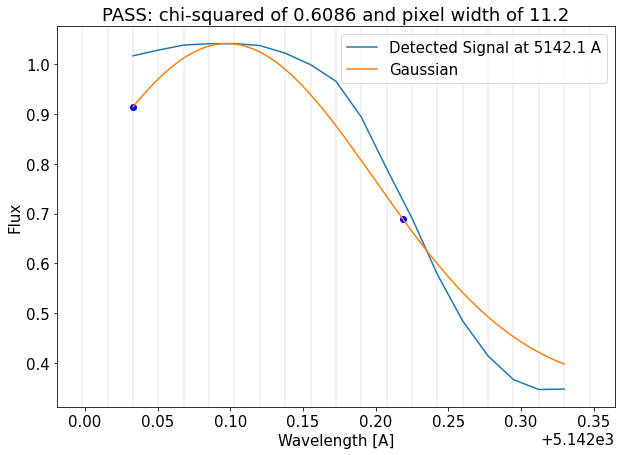

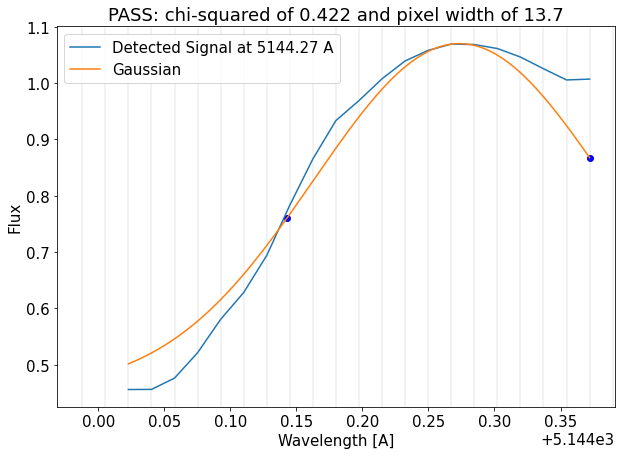

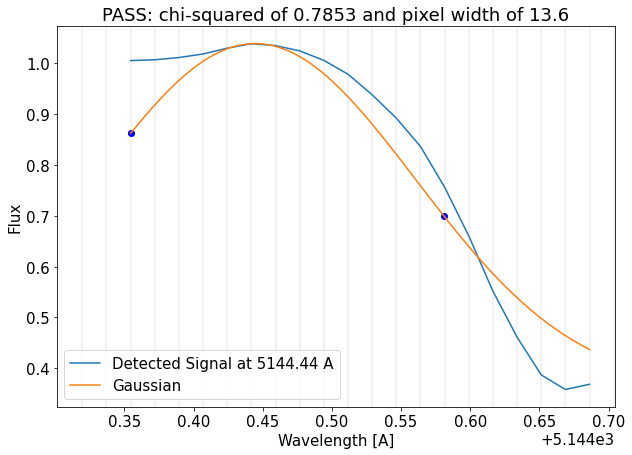

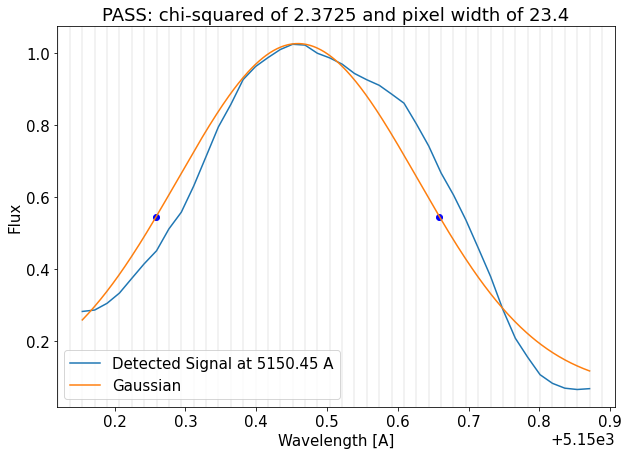

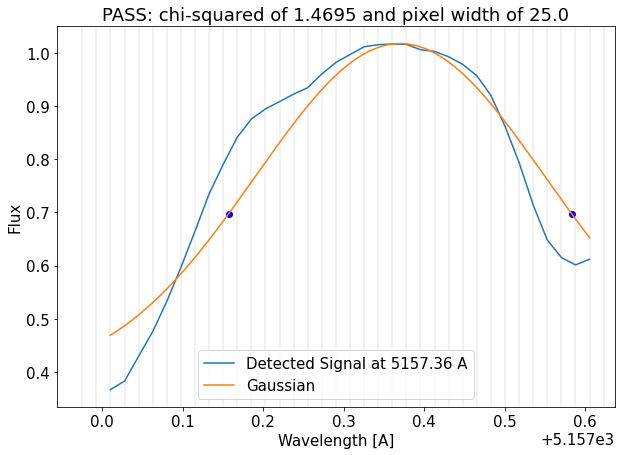

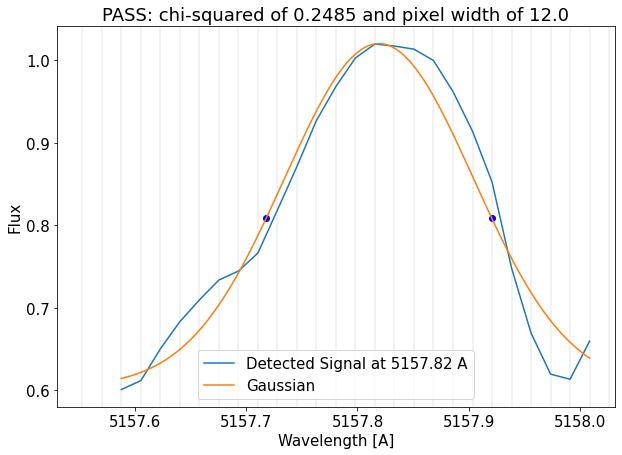

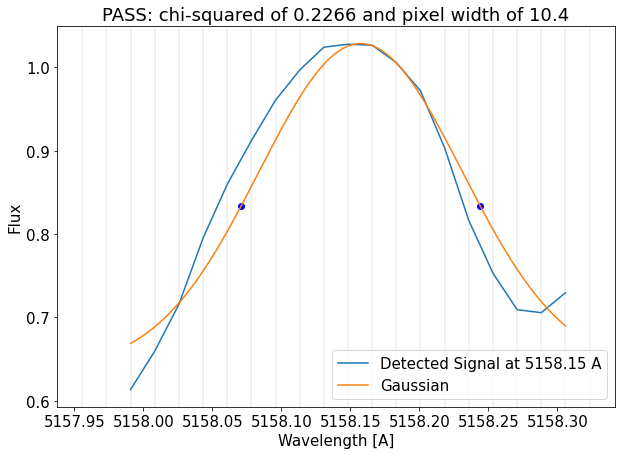

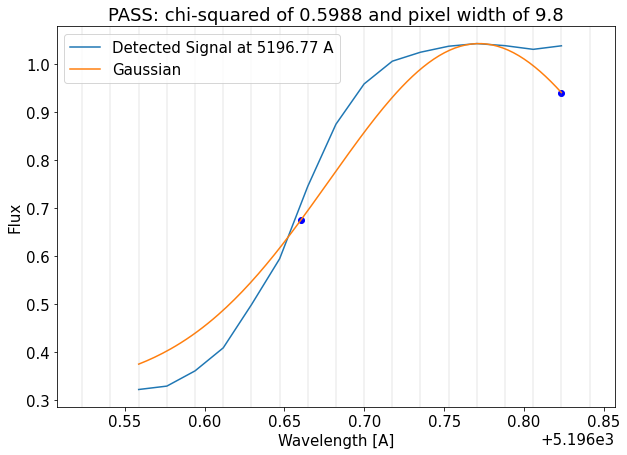

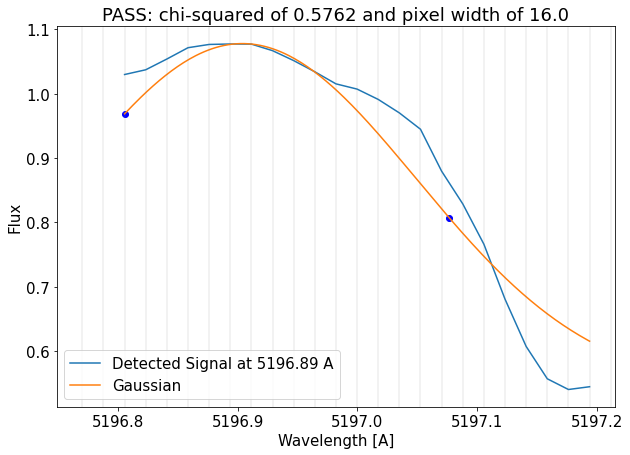

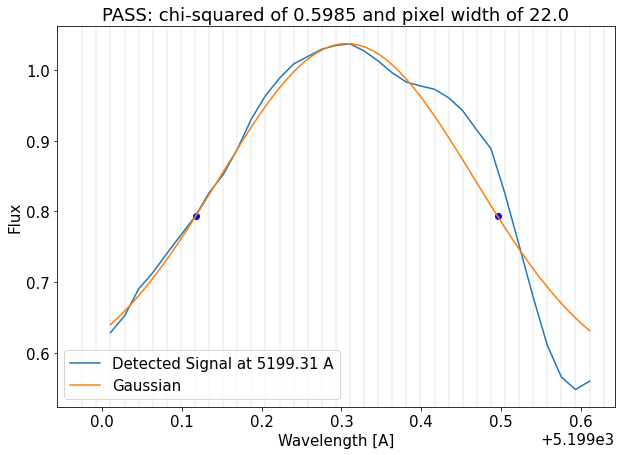

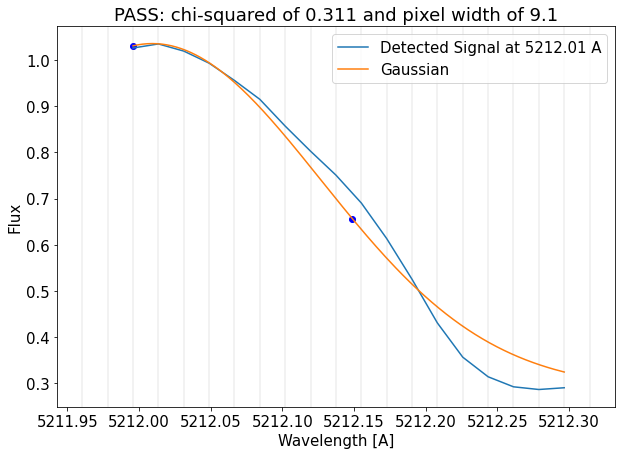

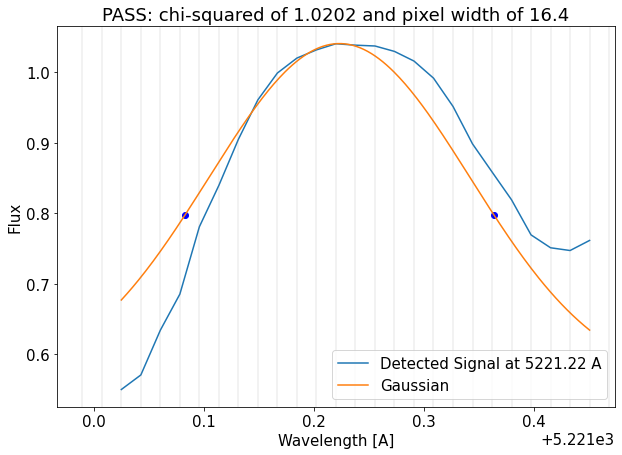

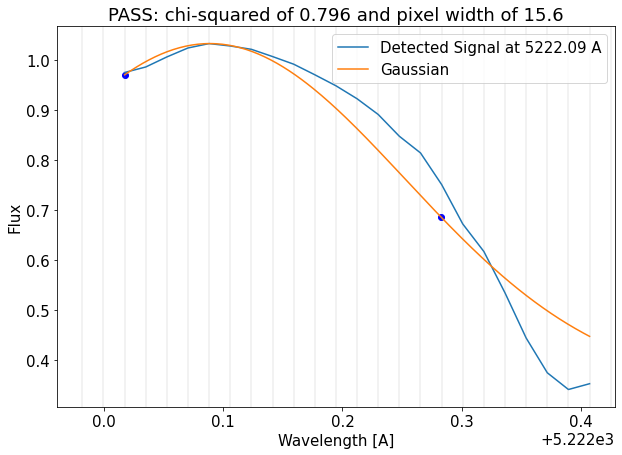

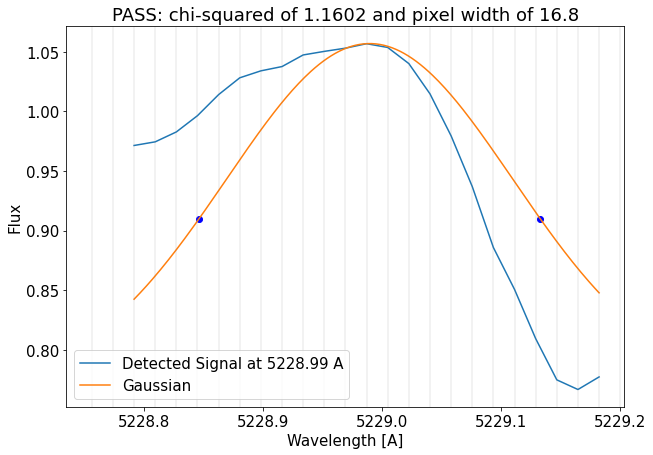

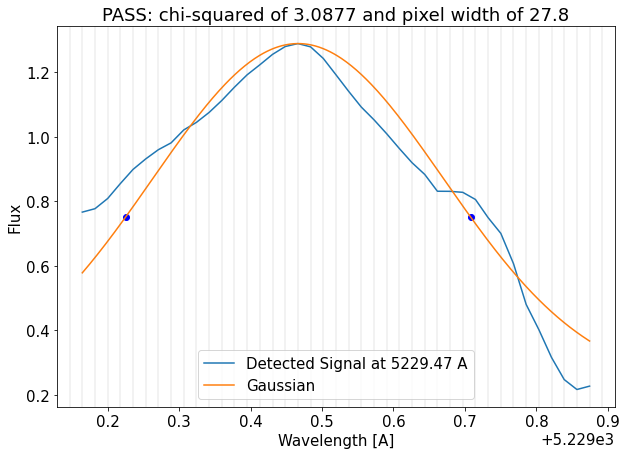

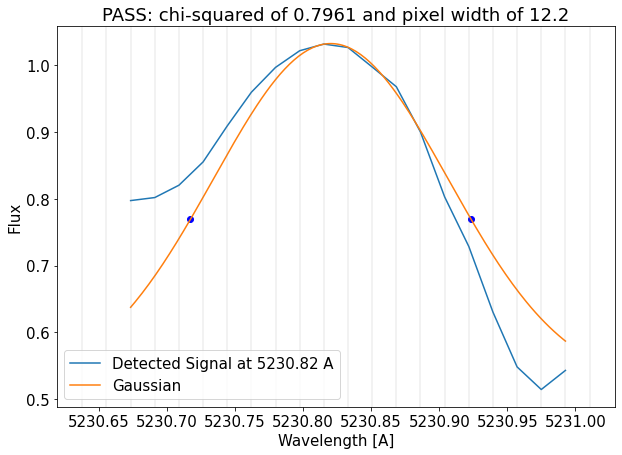

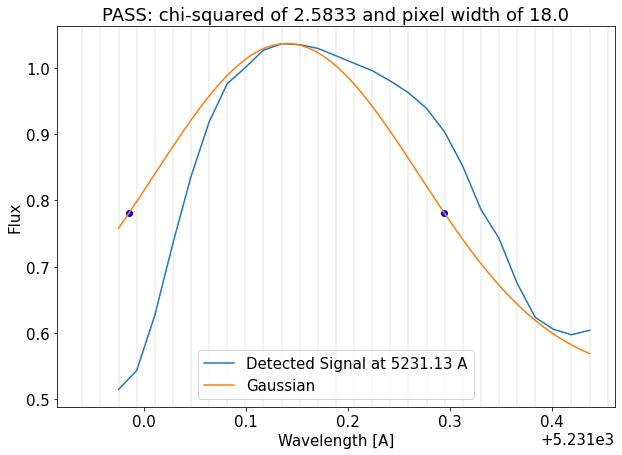

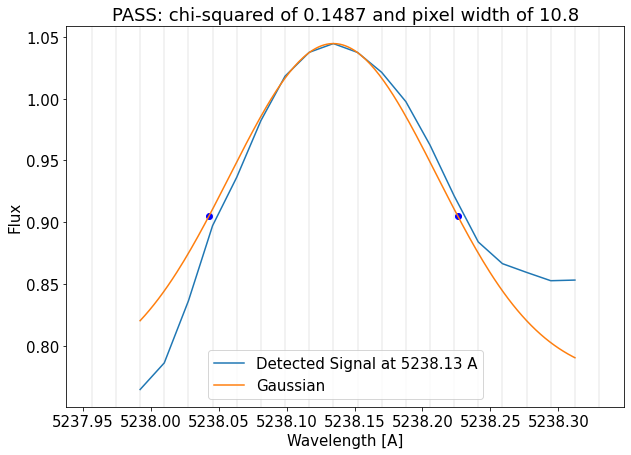

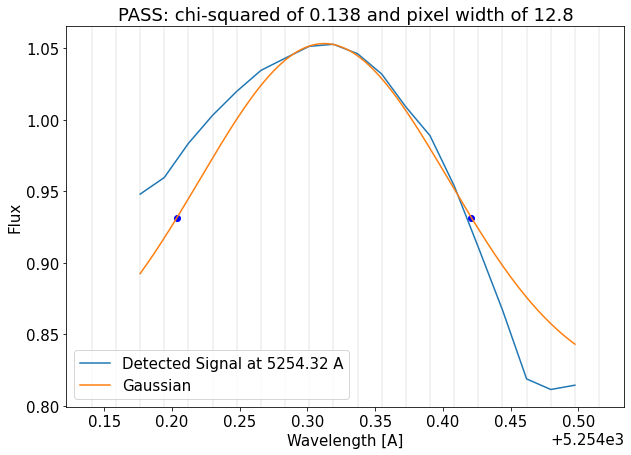

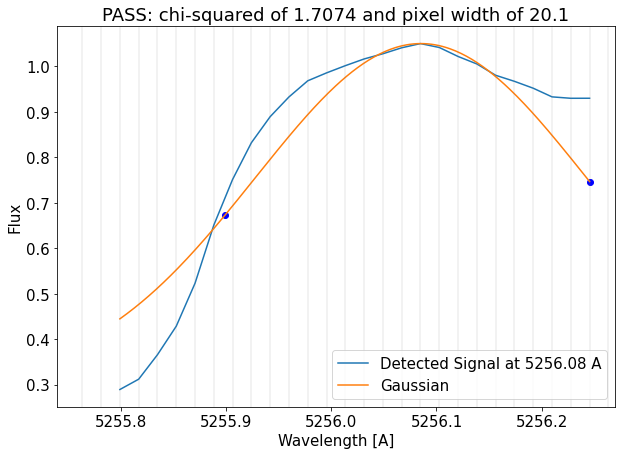

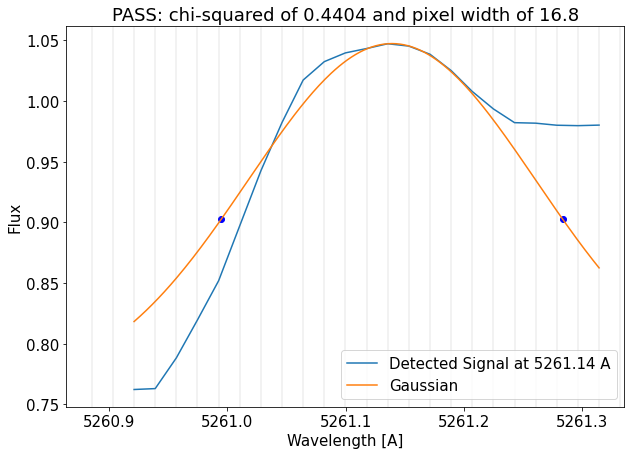

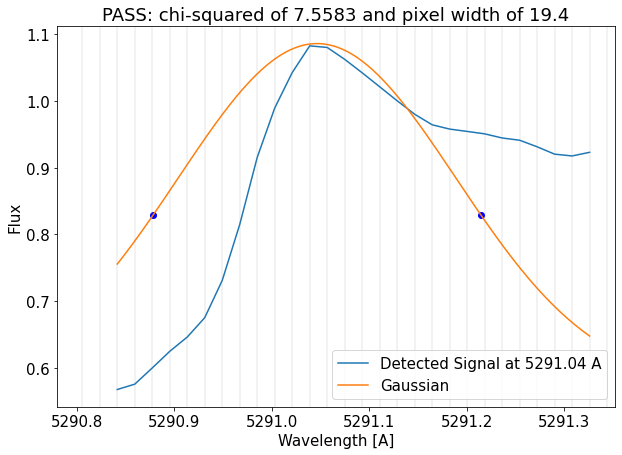

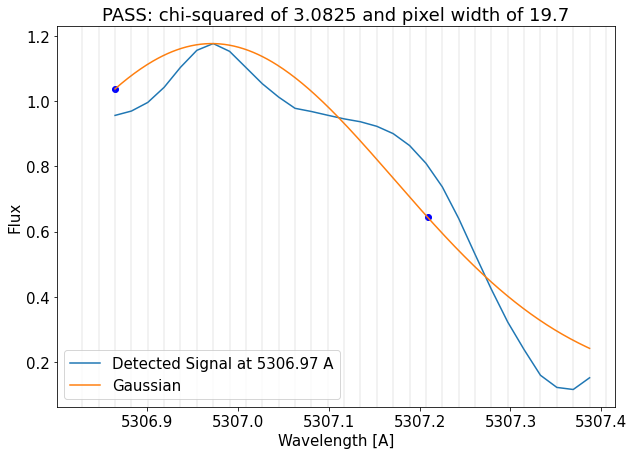

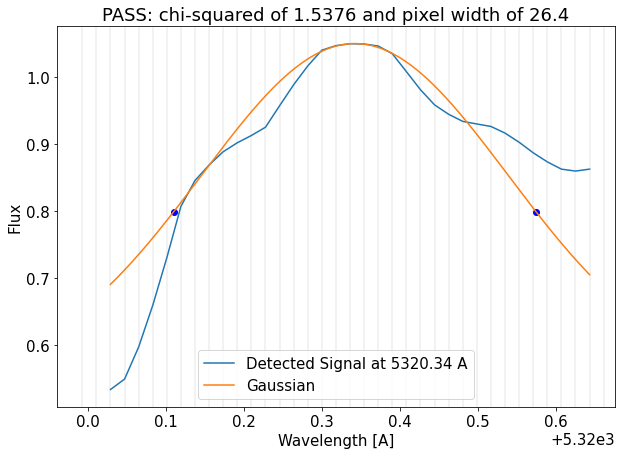

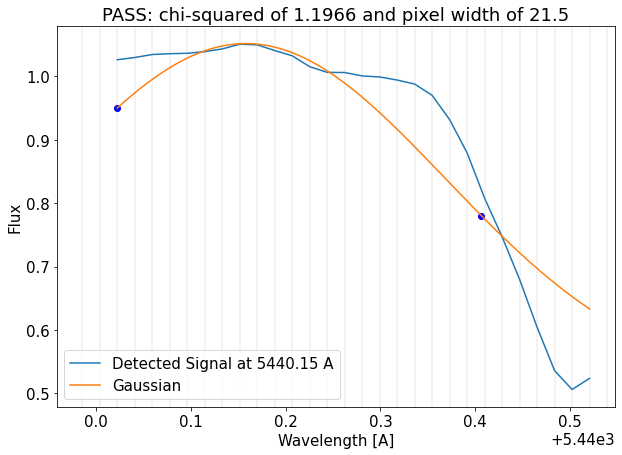

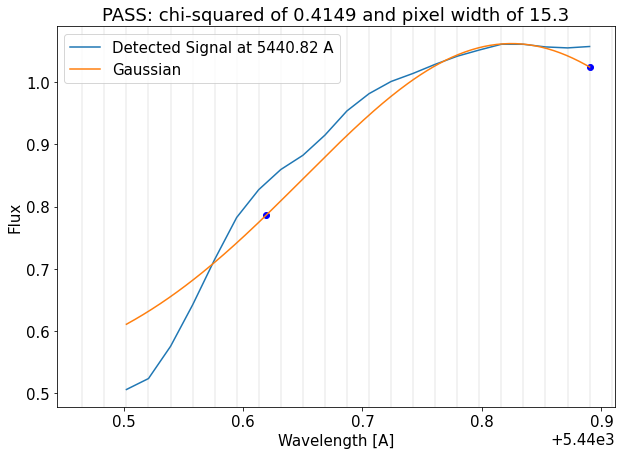

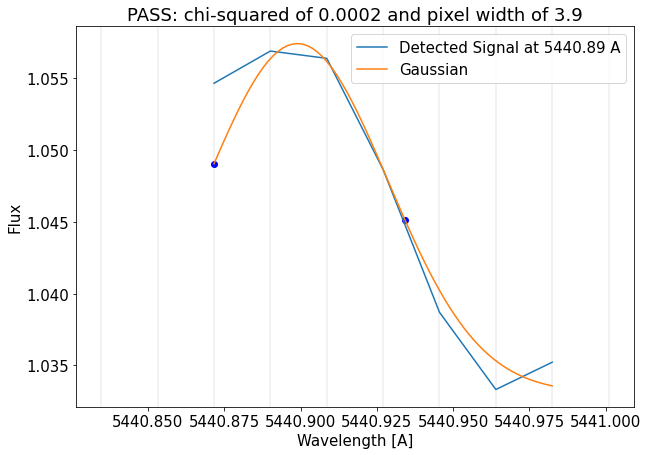

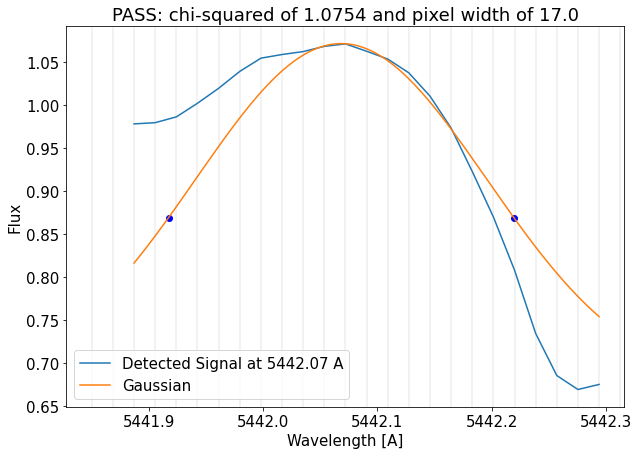

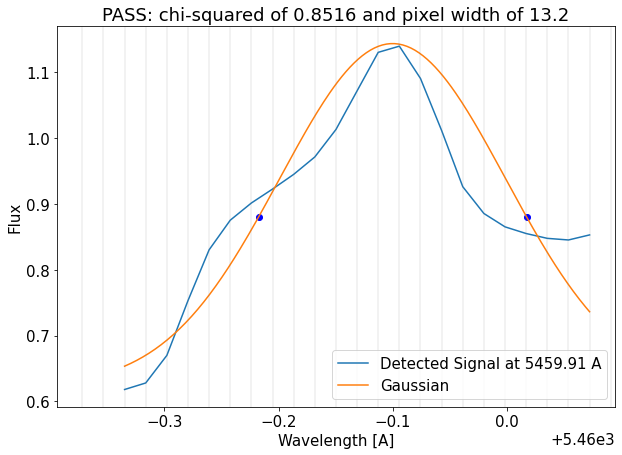

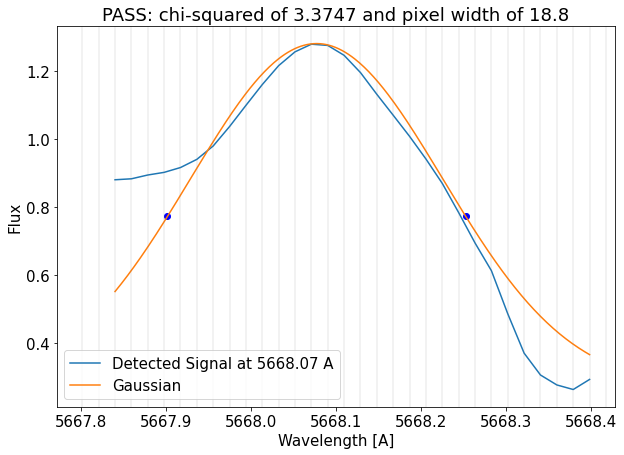

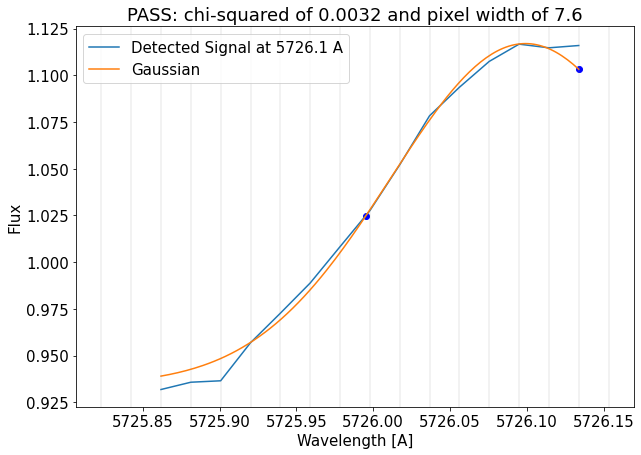

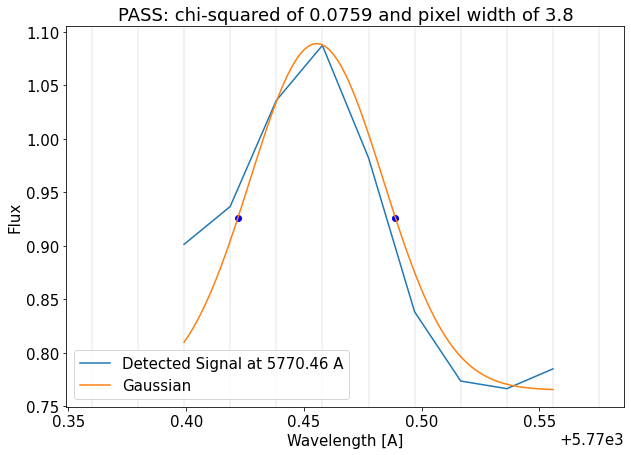

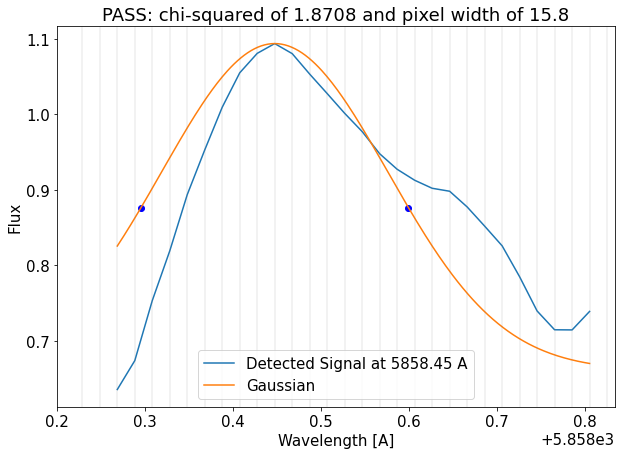

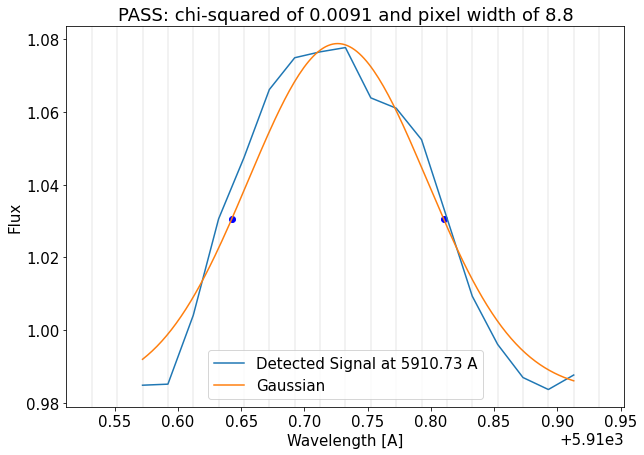

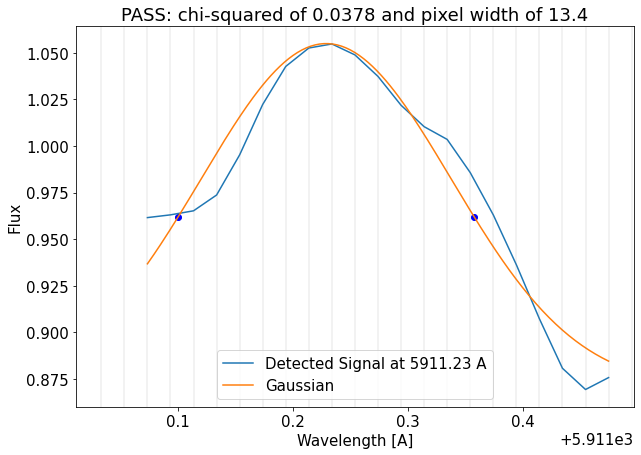

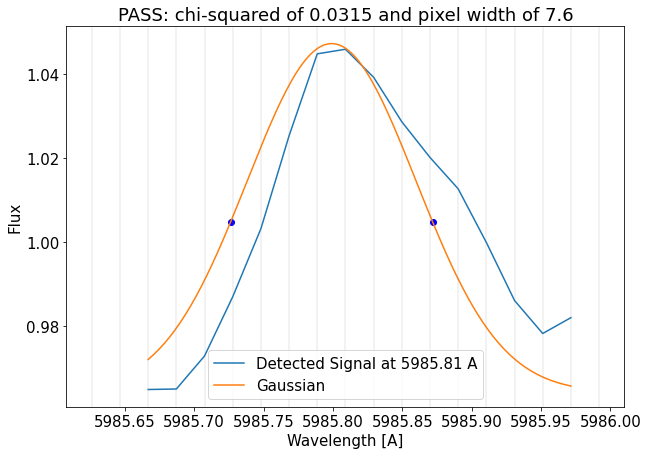

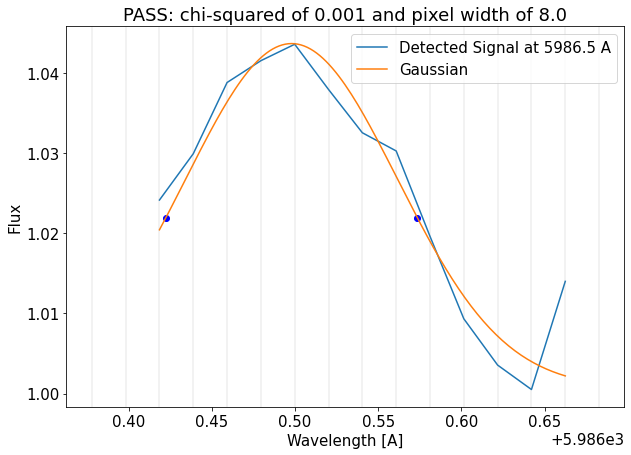

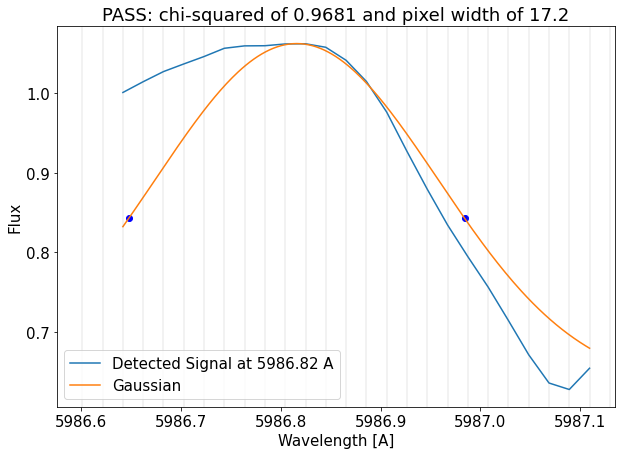

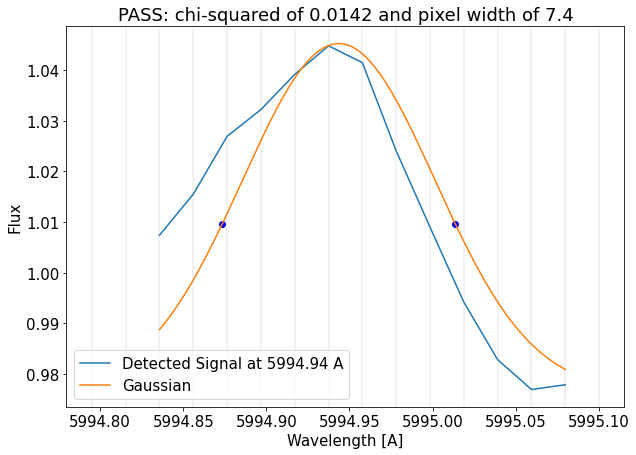

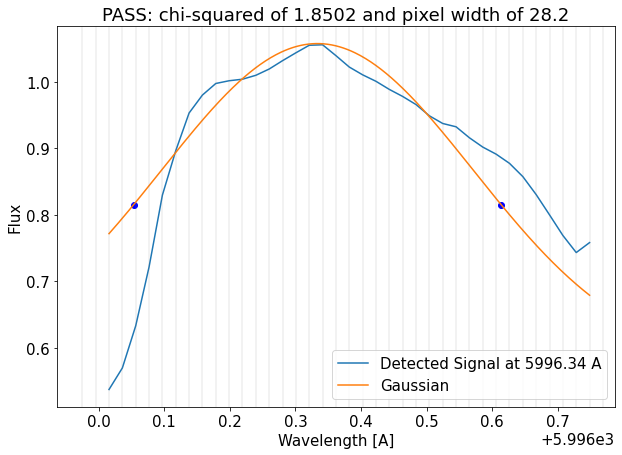

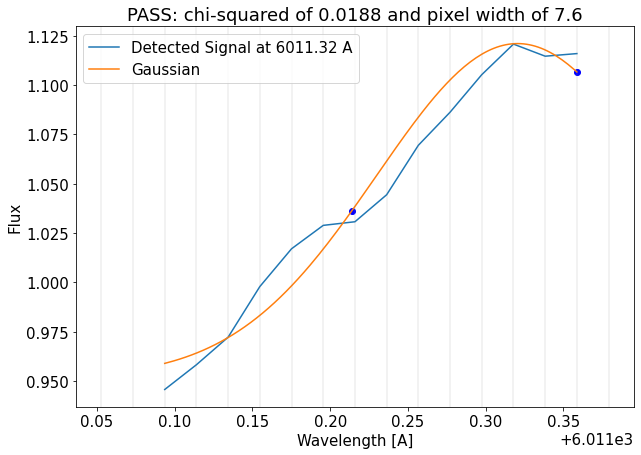

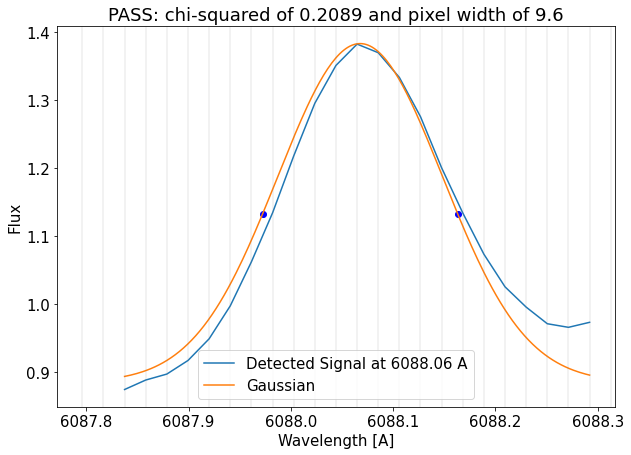

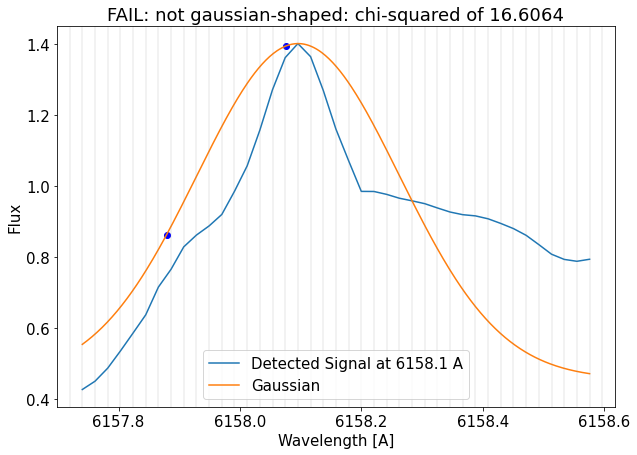

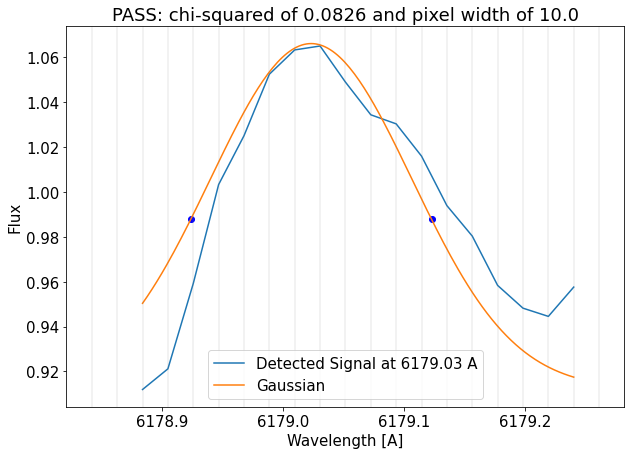

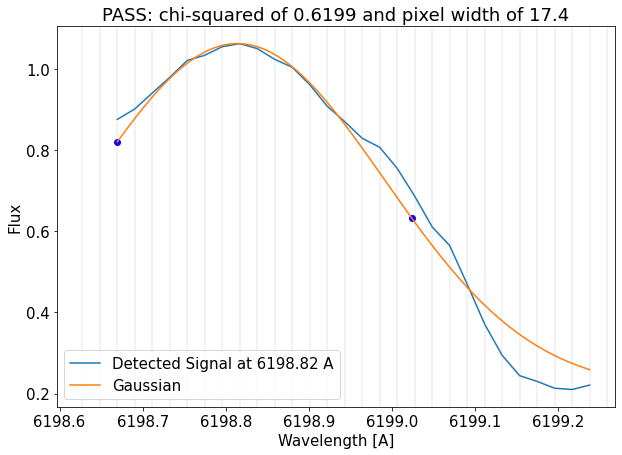

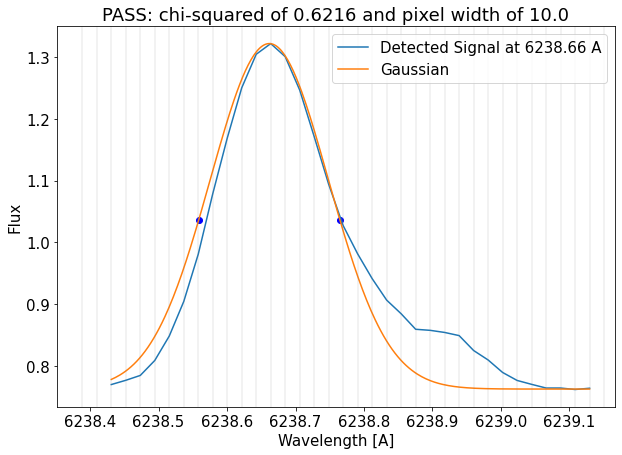

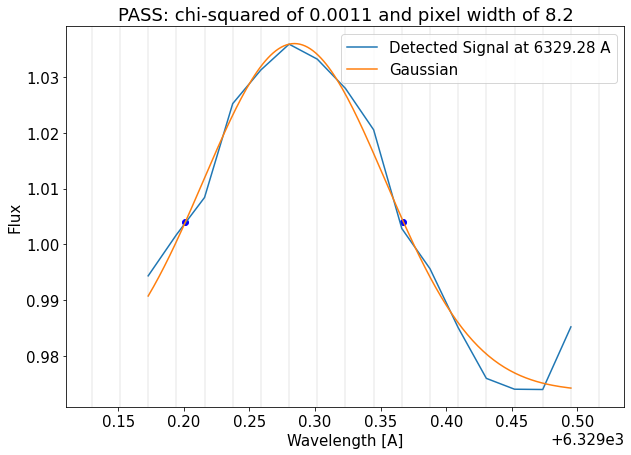

In [55]:
for idx in idxs2:
    # fit a gaussian to the peak, see if the width is greater than or equal to 2 pixels
    # see how much signal resembles a gaussian
    # if last test is commented out, ALSO check FWHM of gaussian
            
    # DETERMINING EDGES OF SIGNAL: mark edge when flux reaches a local minimum
    # PRO: can identify two signals together
    # CON: can't deal with noise in signal
    
    temp_ind = idx
    left_bound = 0
    while temp_ind > 1:
        temp_ind -= 1
        if spect[temp_ind] < spect[temp_ind - 1] and spect[temp_ind] < spect[temp_ind + 1]:
            left_bound = temp_ind
            break
    temp_ind = idx
    right_bound = len(spect) - 1
    while temp_ind < len(spect) - 4:
        temp_ind += 1
        if (spect[temp_ind] < spect[temp_ind - 1]) and (spect[temp_ind] < spect[temp_ind + 1]):
            right_bound = temp_ind
            break

    x = wl[left_bound:right_bound + 2]
    y = spect[left_bound:right_bound + 2]
    
    # oversample detected signal to determine precise bounds on the edges of the signal
    # use this to determine the FWHM of the signal in pixels
    oversampled_x = np.linspace(x[0], x[-1], len(x) * 10)
    spl = splrep(x, y)
    oversampled_y = splev(oversampled_x, spl)
    
    max_y = max(oversampled_y)
    min_y = np.percentile(oversampled_y, 3) 
    height = max_y - min_y
    ind = oversampled_y.tolist().index(max_y)
    pos = oversampled_x[ind]
    min_width = 0.00001
    max_width = oversampled_x[len(oversampled_x) - 1] - oversampled_x[0]
    width_spacing = 0.001

    chi_squared_values = []
    width_vals = np.arange(min_width, max_width, width_spacing)
    for w in width_vals:
        gaus = gaussian(oversampled_x, height, pos, w, min_y)
        chi_squared = chi(gaus, oversampled_y)
        chi_squared_values = np.append(chi_squared_values, chi_squared)
    min_chi_squared = min(chi_squared_values)
    ind_of_min_chisquared = chi_squared_values.tolist().index(min_chi_squared)
    width = width_vals[ind_of_min_chisquared]
    gaus = gaussian(oversampled_x, height, pos, width, min_y)
    
    width_threshold = False
    gauss_threshold = False
    
    # see if the signal fits a gaussian
    if min_chi_squared < 11:
        gauss_threshold = True
        idxs3 = idxs3 + [idx]
        
        # find the width of the gaussian in pixels
    
        peak = max(gaus)
        half_max = peak - height / 2

        peak_index = gaus.tolist().index(peak)
        temp_left_bound = peak_index
        temp_right_bound = peak_index

        while gaus[temp_left_bound] > half_max and temp_left_bound > 0:
            temp_left_bound -=1

        while gaus[temp_right_bound] > half_max and temp_right_bound < len(gaus) - 1:
            temp_right_bound += 1

        pixel_width = (temp_right_bound - temp_left_bound) / 10

        if pixel_width > 2.7:
            width_threshold = True
            idxs4 = idxs4 + [idx]

        else:
            failed_unrecovered_indicies = failed_unrecovered_indicies + [idx]
    else:
        failed_unrecovered_indicies = failed_unrecovered_indicies + [idx]
    
    if plot == True or save_figs == True:
        fig = plt.figure()
        plt.plot(x, y, label = 'Detected Signal at ' + str(round(wl[idx], 2)) + ' A')
        plt.plot(oversampled_x, gaus, label = 'Gaussian')
        plt.scatter(oversampled_x[temp_left_bound], gaus[temp_left_bound], color = 'blue')
        plt.scatter(oversampled_x[temp_right_bound], gaus[temp_right_bound], color = 'blue')
        if width_threshold == True:
            # passed width threshold AND gaussian threshold
            plt.title('PASS: chi-squared of ' + str(round(min_chi_squared, 4)) + ' and pixel width of ' + str(pixel_width))
        elif gauss_threshold == True and width_threshold == False:
            # failed width threshold
            plt.title('FAIL: too narrow with pixel width of ' + str(pixel_width))
        else:
            # failed gaussian threshold
            plt.title('FAIL: not gaussian-shaped: chi-squared of ' + str(round(min_chi_squared, 4)))
            
        plt.xlabel('Wavelength [A]')
        plt.ylabel('Flux')
        for ind in np.arange(left_bound - 2, right_bound + 3):
            plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
        plt.legend()
        if plot == True:
            plt.show()
        if save_figs == True:
            
            # comment out next lines if saving other figs and uncomment out bottom chunk
            path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/ThresholdTesting/'
            if not (os.path.isdir(path)):
                os.mkdir(path)
            if not gauss_threshold:
                fig.savefig(path + str(width) + '_' + str(max_flux_val) + '.png')
            
            
            
            
#             test4_path = path + '/test4'
#             if not (os.path.isdir(test4_path)):
#                 os.mkdir(test4_path)
#             pos_path = test4_path + '/pass'
#             neg_path = test4_path + '/fail'
#             if not (os.path.isdir(pos_path) and os.path.isdir(neg_path)):
#                 os.mkdir(pos_path)
#                 os.mkdir(neg_path)
#             if passed:
#                 fig.savefig(pos_path + '/test4' + '_' + str(round(wl[idx])) + '.png')
#             else:
#                 fig.savefig(neg_path + '/test4' + '_' + str(round(wl[idx])) + '.png')

In [56]:
print(failed_unrecovered_indicies)

[61538]


In [57]:
if threshold_testing == True:

    for idx in idxs4:    
        absolute_difference_function = lambda list_value : abs(list_value - idx)
        i = min(indicies.tolist(), key = absolute_difference_function)
        index = indicies.tolist().index(i)
        if abs(idx - indicies[index]) < 4 and (indicies[index] not in recovered_indicies):
            # add to recovered signals information
            recovered_widths = np.append(recovered_widths, widths[index])
            recovered_heights = np.append(recovered_heights, heights[index])
            recovered_indicies = np.append(recovered_indicies, indicies[index])
            recovered_wavelengths = np.append(recovered_wavelengths, wavelengths[index])
            recovered_max_flux_vals = np.append(recovered_max_flux_vals, max_flux_vals[index])
        else:
            detected_widths = np.append(detected_widths, widths[index])
            detected_heights = np.append(detected_heights, heights[index])
            detected_indicies = np.append(detected_indicies, indicies[index])
#             detected_wavelengths = np.append(detected_wavelengths, wl[index])
            detected_max_flux_vals = np.append(detected_max_flux_vals, spect[index])
    # create a list of failed indicies due to failing the gaussian or width test
    for idx in failed_unrecovered_indicies:  
        i = min(indicies.tolist(), key = absolute_difference_function)
        index = indicies.tolist().index(i)
        if abs(idx - indicies[index]) < 4:
            # add to failed signals information
            failed_unrecovered_widths = np.append(failed_unrecovered_widths, widths[index])
            failed_unrecovered_heights = np.append(failed_unrecovered_heights, heights[index])
            failed_unrecovered_indicies = np.append(failed_unrecovered_indicies, indicies[index])
            failed_unrecovered_wavelengths = np.append(failed_unrecovered_wavelengths, wavelengths[index])
            failed_unrecovered_max_flux_vals = np.append(failed_unrecovered_max_flux_vals, max_flux_vals[index])
            
            
    temp_unrecovered_widths = widths[:]
    for i in recovered_widths:
        if i in temp_unrecovered_widths:
            index_to_remove = temp_unrecovered_widths.tolist().index(i)
            temp_unrecovered_widths = np.delete(temp_unrecovered_widths, index_to_remove)
    unrecovered_widths = np.append(unrecovered_widths, temp_unrecovered_widths)
    
    temp_unrecovered_heights = heights[:]
    for i in recovered_heights:
        if i in temp_unrecovered_heights:
            index_to_remove = temp_unrecovered_heights.tolist().index(i)
            temp_unrecovered_heights = np.delete(temp_unrecovered_heights, index_to_remove)
    unrecovered_heights = np.append(unrecovered_heights, temp_unrecovered_heights)
    
    temp_unrecovered_max_flux_vals = max_flux_vals[:]
    for i in recovered_max_flux_vals:
        if i in temp_unrecovered_max_flux_vals:
            index_to_remove = temp_unrecovered_max_flux_vals.tolist().index(i)
            temp_unrecovered_max_flux_vals = np.delete(temp_unrecovered_max_flux_vals, index_to_remove)
    unrecovered_max_flux_vals = np.append(unrecovered_max_flux_vals, temp_unrecovered_max_flux_vals)

In [58]:
print(unrecovered_heights, unrecovered_widths)

[0.23767076 0.34262395 0.15335923 0.14907671 0.11877035 0.28343858
 0.42208125] [ 4.376 10.229  6.052  5.807  9.498  3.606  6.057]


In [59]:
print(failed_unrecovered_widths)

[6.057]


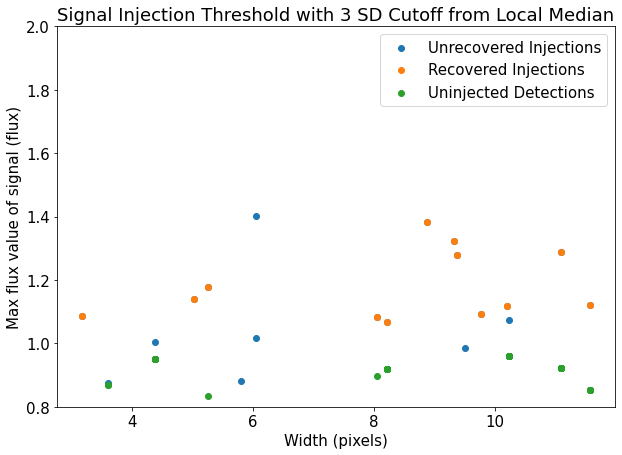

In [60]:
min_width = 7.5
max_width = 8
min_height = 2.8
max_height = 3.3

# %matplotlib notebook

if threshold_testing == True and plot == True or save_figs == True:
    fig = plt.figure()
#     plt.scatter(widths, heights, label = 'Unrecovered Injections') 
#     plt.scatter(recovered_widths, recovered_heights, label = 'Recovered Injections')
#     plt.scatter(detected_widths, detected_heights, label = 'Uninjected Detections')
    plt.scatter(widths, max_flux_vals, label = 'Unrecovered Injections') 
    plt.scatter(recovered_widths, recovered_max_flux_vals, label = 'Recovered Injections')
    plt.scatter(detected_widths, detected_max_flux_vals, label = 'Uninjected Detections')
    
    
    plt.xlabel('Width (pixels)')
    plt.ylabel('Max flux value of signal (flux)')
    if only_test_certain_range == True:
        plt.title('Signal Injection Threshold with ' + str(SDs_above_median) + ' SD Cutoff: One Order')
    else:
        plt.title('Signal Injection Threshold with ' + str(SDs_above_median) + ' SD Cutoff from Local Median')
    plt.legend()
    mplcursors.cursor(hover=True)
    if plot == True:
#         plt.xlim(min_width, max_width)
#         plt.ylim(min_height, max_height)
        plt.ylim(0.8, 2)
        plt.show()
    if save_figs == True:
        threshold_path = path + '/' + star + 'threshold'
        fig.savefig(threshold_path)

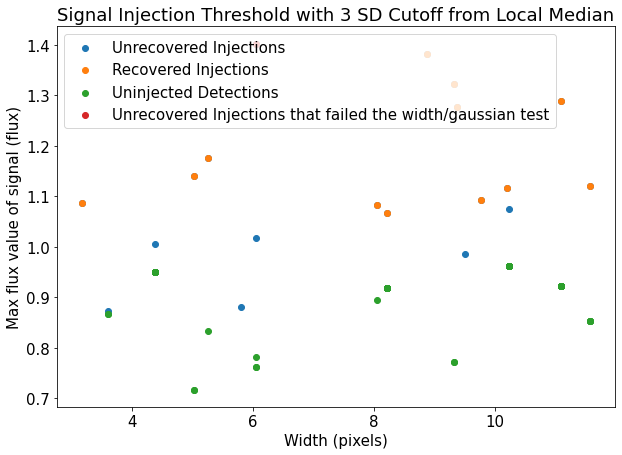

In [61]:

fig = plt.figure()
plt.scatter(widths, max_flux_vals, label = 'Unrecovered Injections') 
plt.scatter(recovered_widths, recovered_max_flux_vals, label = 'Recovered Injections')
plt.scatter(detected_widths, detected_max_flux_vals, label = 'Uninjected Detections')
plt.scatter(failed_unrecovered_widths, failed_unrecovered_max_flux_vals, label = 'Unrecovered Injections that failed the width/gaussian test')


plt.xlabel('Width (pixels)')
plt.ylabel('Max flux value of signal (flux)')
plt.title('Signal Injection Threshold with ' + str(SDs_above_median) + ' SD Cutoff from Local Median')
plt.legend()
# plt.ylim(0.8, 2)
plt.show()


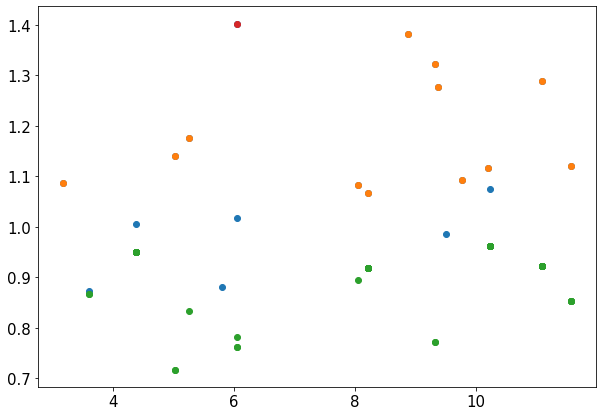

In [62]:
plt.scatter(widths, max_flux_vals, label = 'Unrecovered Injections') 
plt.scatter(recovered_widths, recovered_max_flux_vals, label = 'Recovered Injections')
plt.scatter(detected_widths, detected_max_flux_vals, label = 'Uninjected Detections')
plt.scatter(failed_unrecovered_widths, failed_unrecovered_max_flux_vals, label = 'Unrecovered Injections that failed the width/gaussian test')
plt.show()